In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from enum import Enum
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
from itertools import product
from copy import deepcopy
import matplotlib.colors as mcolors


In [2]:
# Editable Globals
PLAYABLE_GRID_SIZE = 10 # Playable grid without walls.  Minimum value = 5
WALL_PENALTY = -2_000
MOVEMENT_BONUS = 100
APPLE_BONUS = 10_000
WIN_BONUS = 10_000_000
STARTING_SCORE = 2000
EPSILON = .9995
LEARNING_RATE = 1e-1
PRINT_FREQUENCY = 50
EPISODES = 10000

In [3]:
# These globals are derived, don't edit unless refactoring
TOTAL_GRID_SIZE = PLAYABLE_GRID_SIZE + 2             # Playable Area + Walls
MAX_SNAKE_LENGTH = PLAYABLE_GRID_SIZE ** 2 - 1
STARTING_HEAD_LOCATION = (TOTAL_GRID_SIZE//2, TOTAL_GRID_SIZE//2)
STARTING_APPLE_LOCATION = (TOTAL_GRID_SIZE//2 + 1, TOTAL_GRID_SIZE//2)
EMPTY_GRID_SET = set((i, j) for i, j in product(range(1, TOTAL_GRID_SIZE), repeat=2))
empty_grid_nested_list = [[0 for _ in range(TOTAL_GRID_SIZE)] for _ in range(TOTAL_GRID_SIZE)]
for i in range(TOTAL_GRID_SIZE):
    empty_grid_nested_list[0][i] = empty_grid_nested_list[i][0] = empty_grid_nested_list[TOTAL_GRID_SIZE -1][i] = empty_grid_nested_list[i][TOTAL_GRID_SIZE - 1] = 3
EMPTY_GRID_NESTED_LIST = empty_grid_nested_list
class Direction(Enum):
    UP =    [1, 0, 0, 0]
    DOWN =  [0, 1, 0, 0]
    LEFT =  [0, 0, 1, 0]
    RIGHT = [0, 0, 0, 1]


def eat_apple(snake_queue):
    """
    Generate a new apple location that's not within the snake's current position.

    Args:
    - snake_queue (list): List of tuples representing the snake's current positions.

    Returns:
    - tuple: New apple location.
    """
    available_locations = EMPTY_GRID_SET - set(snake_queue)
    new_apple_location = random.choice(list(available_locations))
    return new_apple_location

def initialize_game():
    """
    Initialize the snake's starting position and the first apple's position.

    Returns:
    - snake_queue (list): List of tuples representing the snake's initial position.
    - apple_location (tuple): Initial apple location.
    """
    # Initialize the snake queue with the head location
    snake_queue = [STARTING_HEAD_LOCATION]
    apple_location = STARTING_APPLE_LOCATION
    score = STARTING_SCORE
    distance_to_apple = ((STARTING_HEAD_LOCATION[0]-STARTING_APPLE_LOCATION[0])**2 + (STARTING_HEAD_LOCATION[1]-STARTING_APPLE_LOCATION[1])**2)**0.5
    distance_traveled_to_apple = 0
    game_over = False
    return game_over, snake_queue, apple_location, distance_traveled_to_apple, distance_to_apple, score

def update_state(snake_queue, apple_location, distance_traveled_to_apple, direction, score):
    """
    Update the snake's position based on the given direction.
    """
    
    def move_snake(snake_queue, direction):
        head_location = snake_queue[-1]
        # Update head_location based on the direction
        if direction == Direction.UP: # Up
            head_location = (head_location[0]-1, head_location[1])
        elif direction == Direction.DOWN: # Down
            head_location = (head_location[0]+1, head_location[1])
        elif direction == Direction.LEFT: # Left
            head_location = (head_location[0], head_location[1]-1)
        else: # Right
            head_location = (head_location[0], head_location[1]+1)
        return head_location

    def score_and_process_move(head_location, snake_queue, apple_location, distance_traveled_to_apple, score):
        # Check if snake ate itself or a wall
        distance_traveled_to_apple += 1
        if (head_location in snake_queue) or (head_location[0] in [0, TOTAL_GRID_SIZE - 1] or head_location[1] in [0, TOTAL_GRID_SIZE - 1]):
            score += WALL_PENALTY
            return True, snake_queue, apple_location, distance_traveled_to_apple, score
        # Check if snake ate apple
        elif head_location == apple_location:
            score += APPLE_BONUS / distance_traveled_to_apple
            apple_location = eat_apple(snake_queue)
            snake_queue.append(head_location)
            distance_traveled_to_apple = 0
        # Snake just moves
        else:
            score += MOVEMENT_BONUS
            snake_queue.append(head_location)
            snake_queue.pop(0)
        if len(snake_queue) == MAX_SNAKE_LENGTH:
            score += WIN_BONUS
            return True, snake_queue, apple_location, distance_traveled_to_apple, score
        return False, snake_queue, apple_location, distance_traveled_to_apple, score

    return score_and_process_move(move_snake(snake_queue, direction), snake_queue, apple_location, distance_traveled_to_apple, score)


In [4]:
def plot_game_board(grid):
    """
    Visualizes the game board using matplotlib.

    Args:
    - grid (2D list): The game grid.
    """
    
    # Convert the grid to numpy array for easier indexing
    grid = np.array(grid)

    # Define a colormap: list of color names
    cmap = mcolors.ListedColormap(['white', 'green', 'red', 'black'])
    
    # Set the bounds for the colormap
    bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # Plot
    fig, ax = plt.subplots()
    ax.imshow(grid, cmap=cmap, norm=norm)

    # Hide the axis
    ax.axis('off')
    
    plt.show()

In [5]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )
    
    def forward(self, x):
        return self.fc(x)

In [6]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        experience = (state, action, reward, next_state, done)
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(
            *random.sample(self.buffer, batch_size))
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch
    
    def __len__(self):
        return len(self.buffer)

In [7]:
class DQNAgent:
    def __init__(self, input_dim, output_dim, gamma=0.99, learning_rate=LEARNING_RATE, buffer_size=1000, batch_size=64):
        self.dqn = DQN(input_dim, output_dim).to(device)
        self.target = DQN(input_dim, output_dim).to(device)
        self.target.load_state_dict(self.dqn.state_dict())
        self.target.eval() # Set the target network to evaluation mode
        
        self.optimizer = optim.Adam(self.dqn.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()
        self.buffer = ReplayBuffer(buffer_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = 1.0
    
    def update(self):
        if len(self.buffer) < self.batch_size:
            return
        state, action, reward, next_state, done = self.buffer.sample(self.batch_size)
        
        # Convert to tensors
        state = torch.FloatTensor(state).to(device)
        action = torch.LongTensor(action).to(device)
        reward = torch.FloatTensor(reward).to(device)
        next_state = torch.FloatTensor(next_state).to(device)
        done = torch.FloatTensor(done).to(device)
        
        # Compute Q-values
        curr_Q = self.dqn(state).gather(1, action.unsqueeze(1))
        curr_Q = curr_Q.squeeze(1)
        next_Q = self.target(next_state).max(1)[0]
        expected_Q = reward + (1 - done) * self.gamma * next_Q
        
        # Compute loss and update the network
        loss = self.loss_fn(curr_Q, expected_Q.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            if random.random() > self.epsilon:
                action_index = int(self.dqn(state).max(1)[1])
            else:
                action_index = random.randint(0, 3) # Number of actions - 1

        # Map action_index to Direction enum
        
        return action_index

                
    def decay_epsilon(self):
        self.epsilon *= EPSILON
        self.epsilon = max(self.epsilon, 0.01)
        
    def sync_target(self):
        self.target.load_state_dict(self.dqn.state_dict())

In [8]:
def encode_state(snake_queue, apple_location, distance_traveled_to_apple, score):
    grid = [row[:] for row in EMPTY_GRID_NESTED_LIST]
    
    for segment in snake_queue:
        grid[segment[0]][segment[1]] = 1

    # Add this line to identify the snake's head
    head = snake_queue[-1]
    grid[head[0]][head[1]] = 4
        
    grid[apple_location[0]][apple_location[1]] = 2
    
    for i in range(TOTAL_GRID_SIZE):
        grid[0][i] = grid[i][0] = grid[TOTAL_GRID_SIZE - 1][i] = grid[i][TOTAL_GRID_SIZE - 1] = 3

    flat_grid = [cell for row in grid for cell in row]
    
    normalized_distance_traveled_to_apple = distance_traveled_to_apple / PLAYABLE_GRID_SIZE ** 2
    distance = ((head[0] - apple_location[0]) ** 2 + (head[1] - apple_location[1]) ** 2) ** 0.5
    normalized_distance_to_apple = distance / (2 * PLAYABLE_GRID_SIZE)
    
    state = flat_grid + [normalized_distance_traveled_to_apple, normalized_distance_to_apple, score]
    
    return state


In [9]:

def plot_series(iterations_per_episode, scores_per_episode):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(iterations_per_episode)
    plt.title("Iterations per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Iterations")

    plt.subplot(1, 2, 2)
    plt.plot(scores_per_episode)
    plt.title("Score per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Score")

    plt.tight_layout()
    plt.show()


49


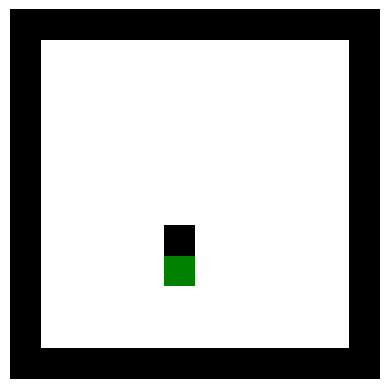

99


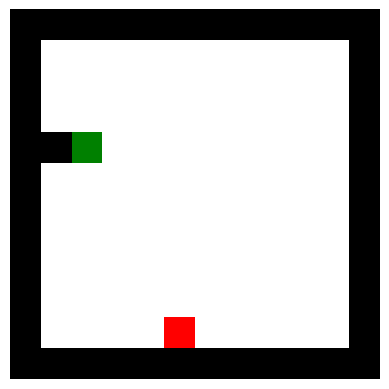

149


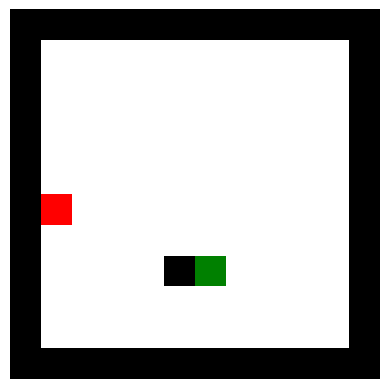

199


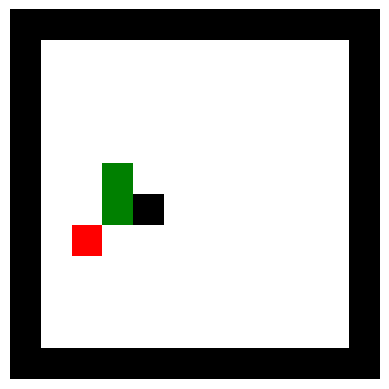

249


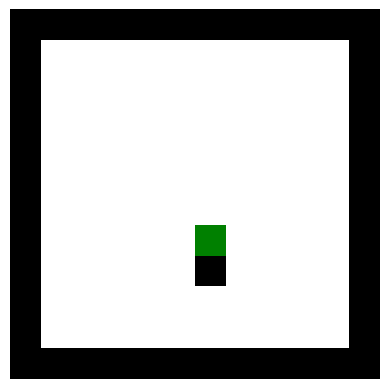

299


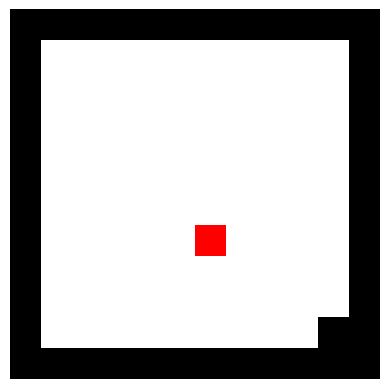

349


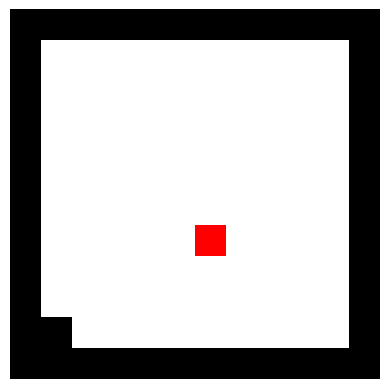

399


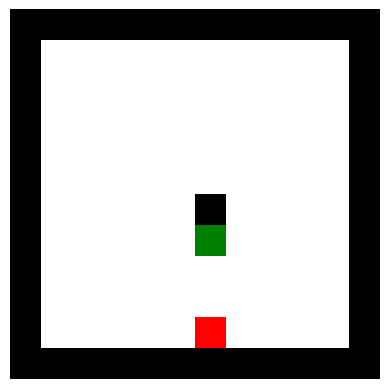

449


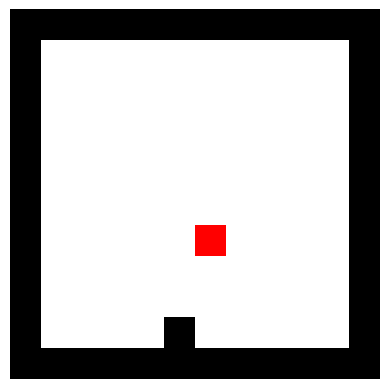

499


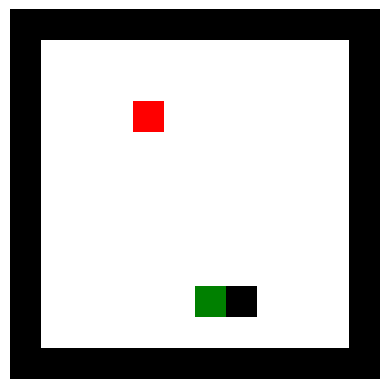

549


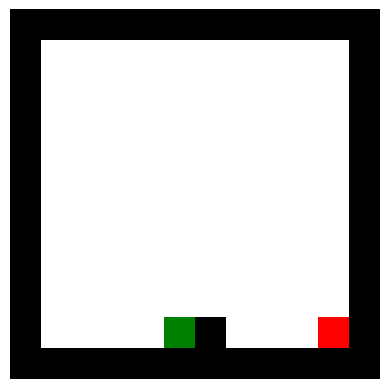

599


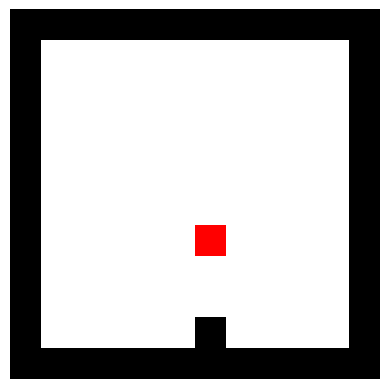

649


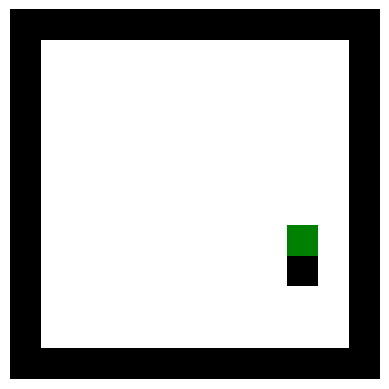

699


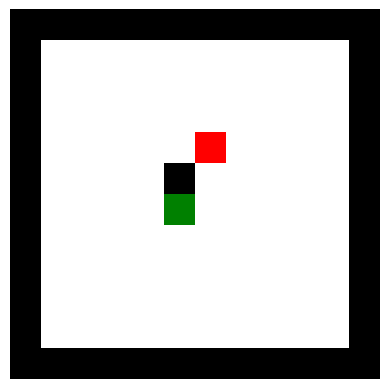

749


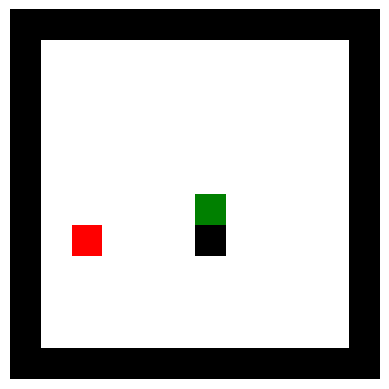

799


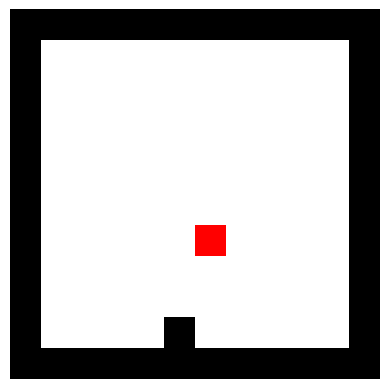

849


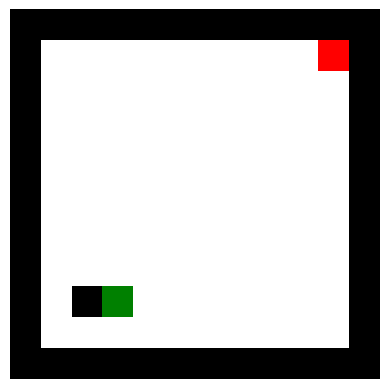

899


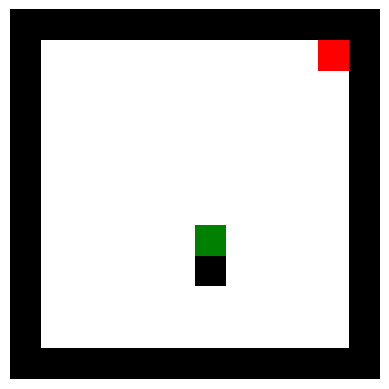

949


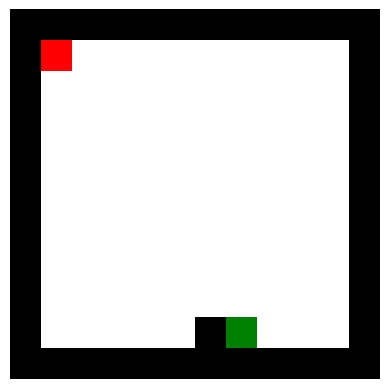

999


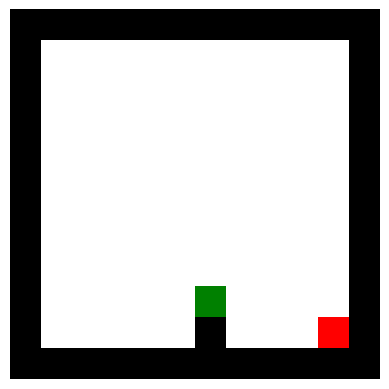

1049


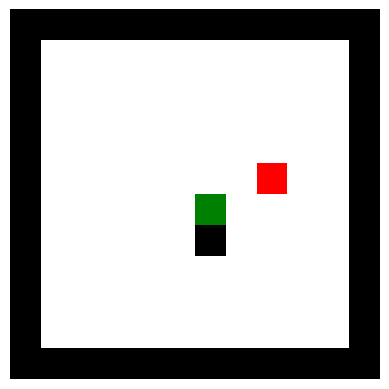

1099


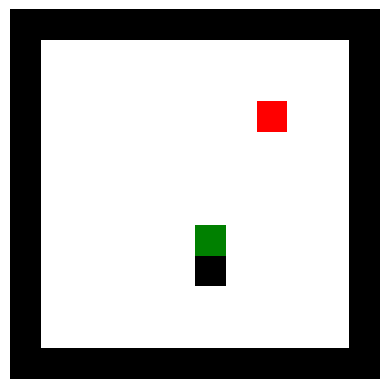

1149


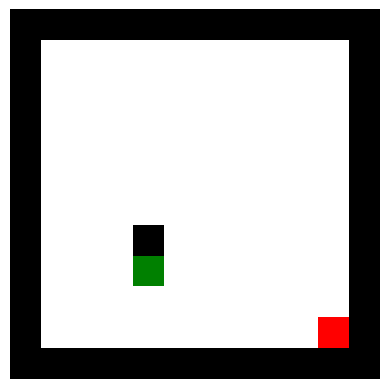

1199


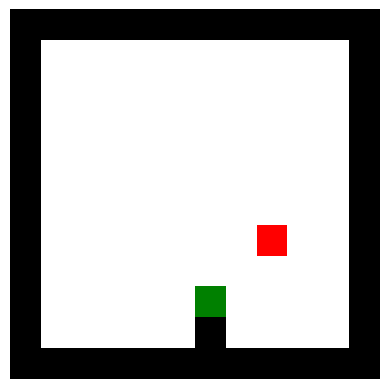

1249


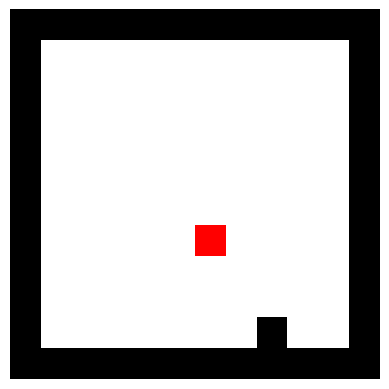

1299


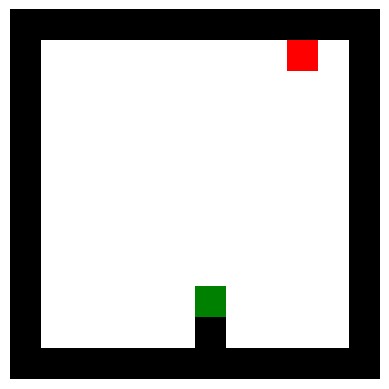

1349


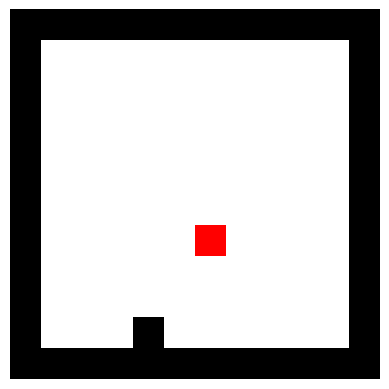

1399


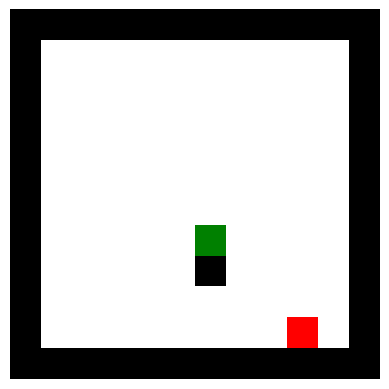

1449


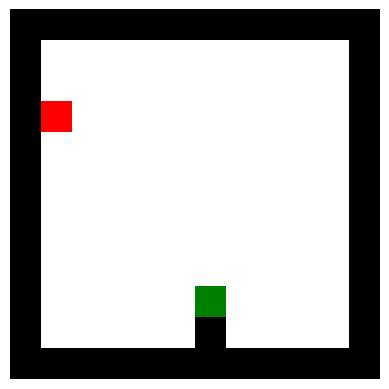

1499


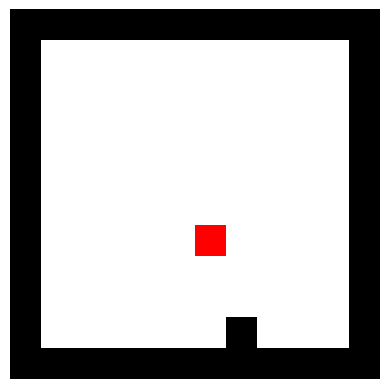

1549


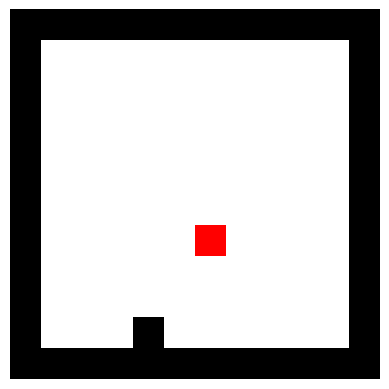

1599


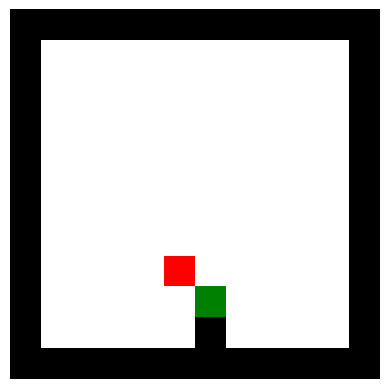

1649


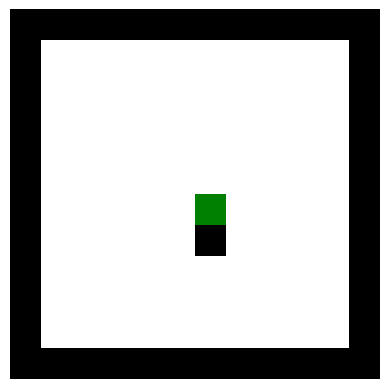

1699


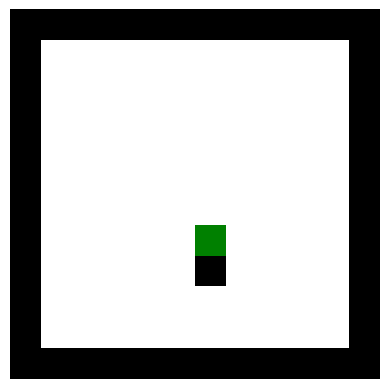

1749


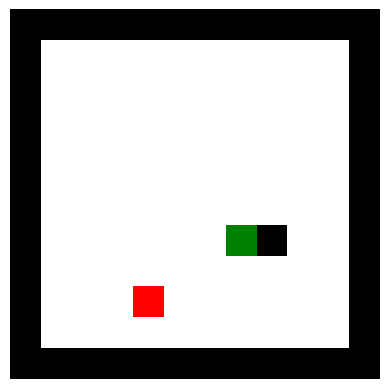

1799


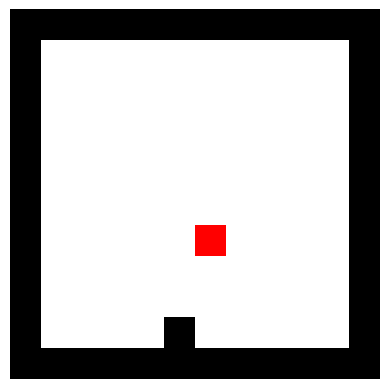

1849


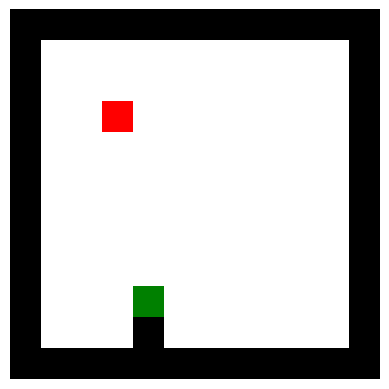

1899


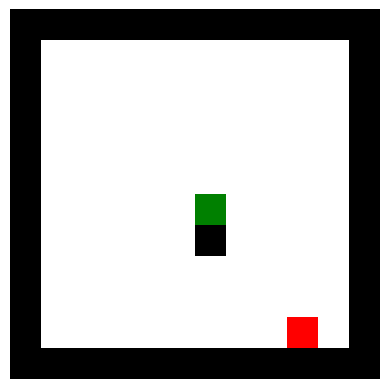

1949


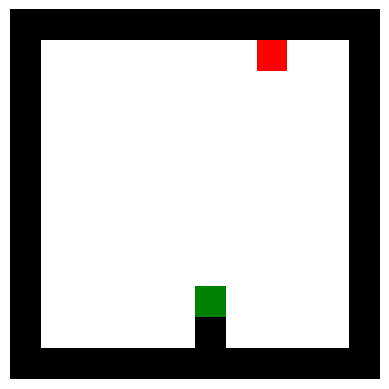

1999


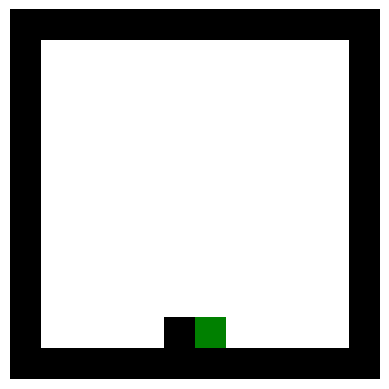

2049


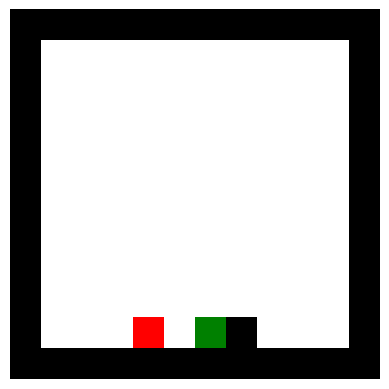

2099


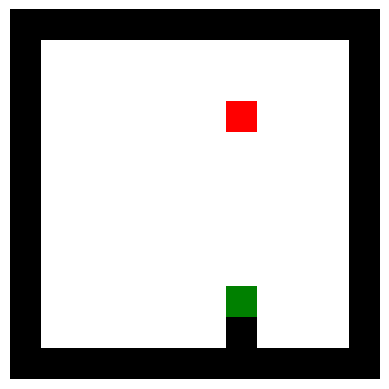

2149


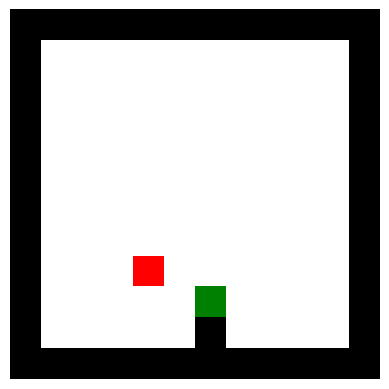

2199


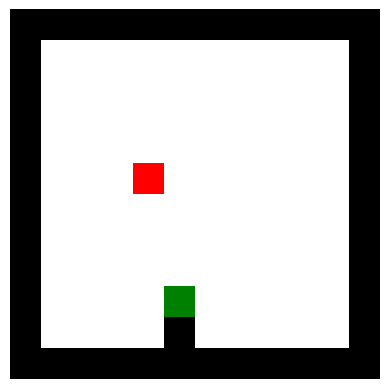

2249


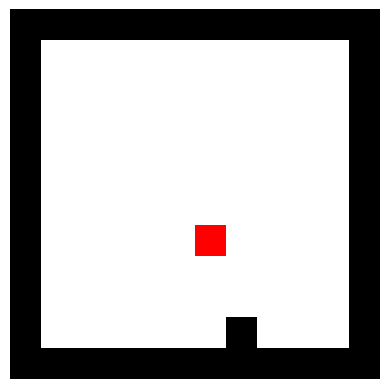

2299


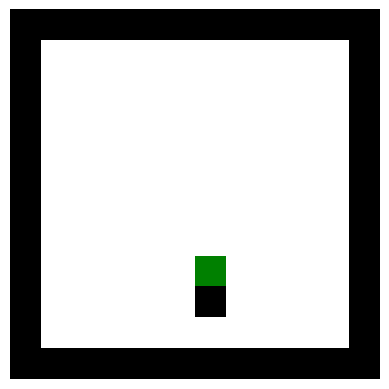

2349


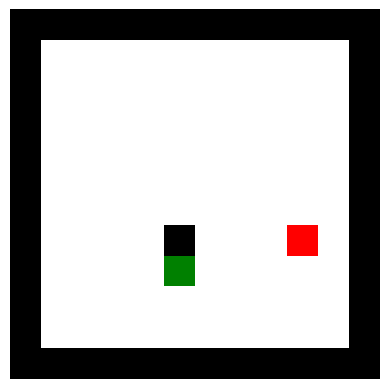

2399


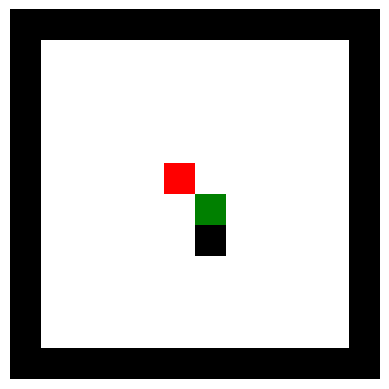

2449


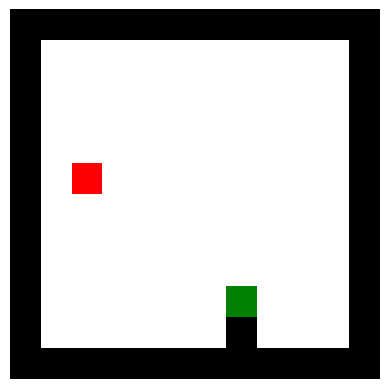

2499


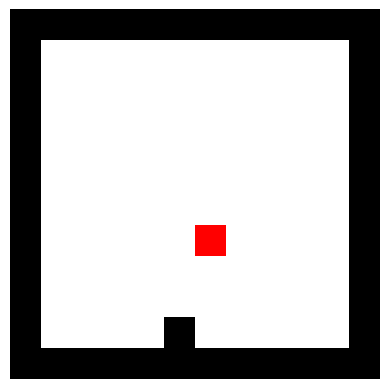

2549


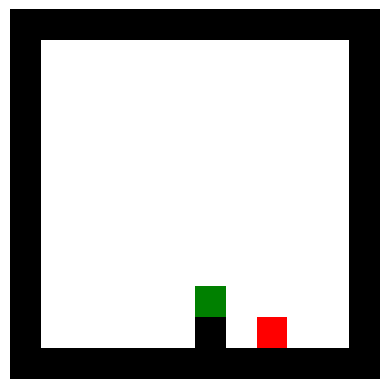

2599


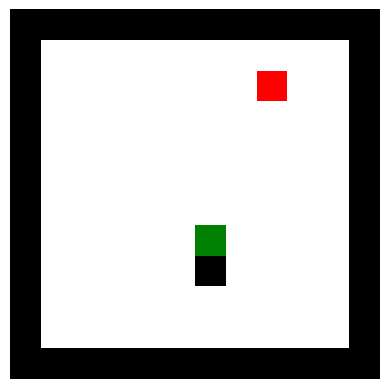

2649


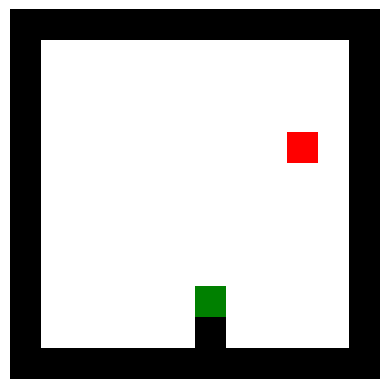

2699


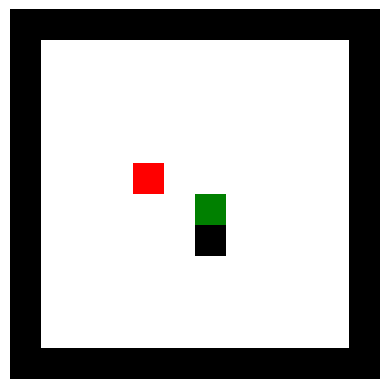

2749


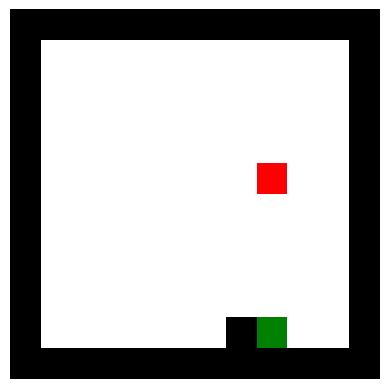

2799


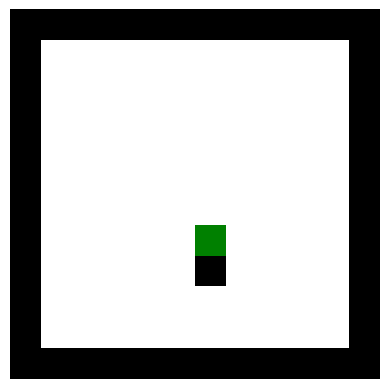

2849


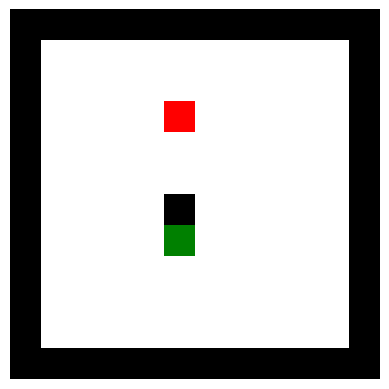

2899


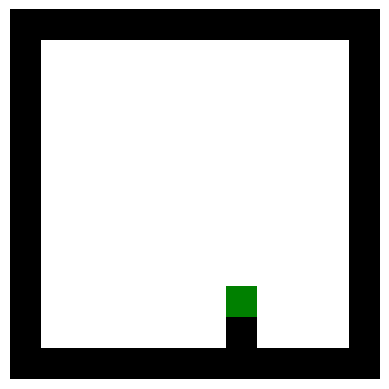

2949


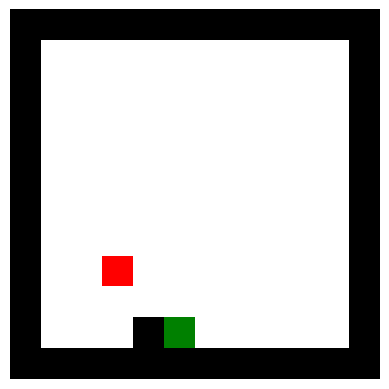

2999


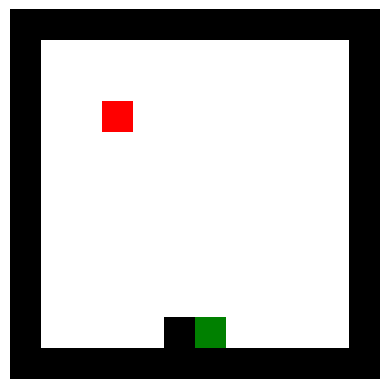

3049


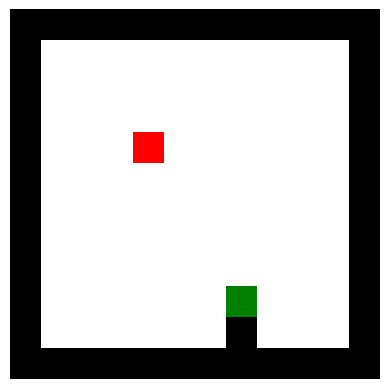

3099


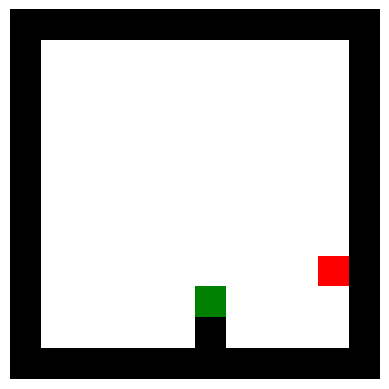

3149


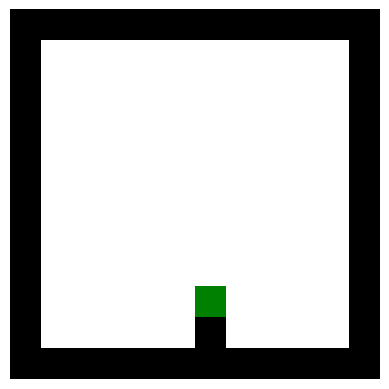

3199


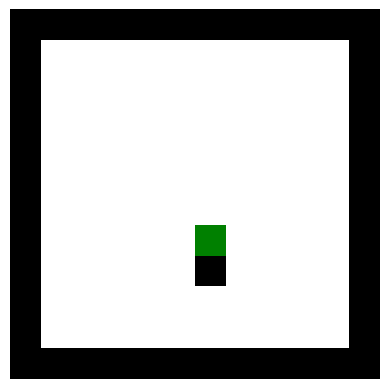

3249


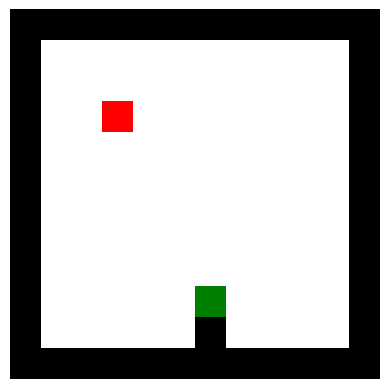

3299


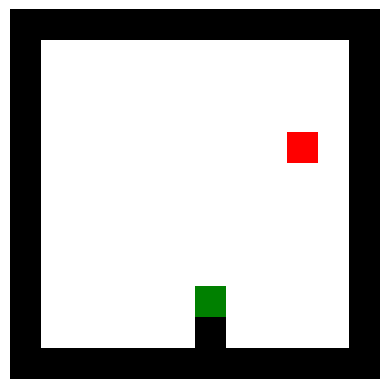

3349


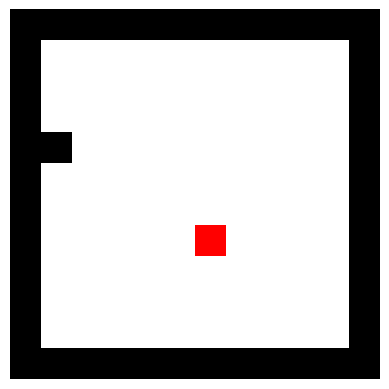

3399


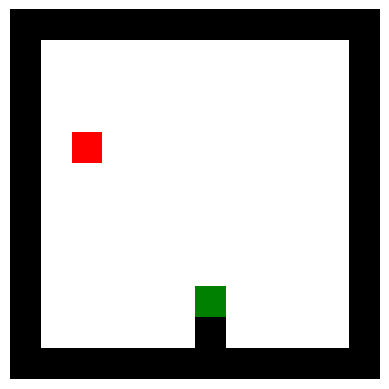

3449


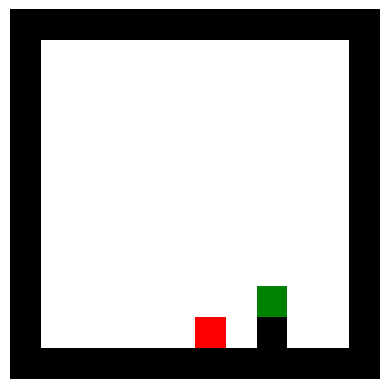

3499


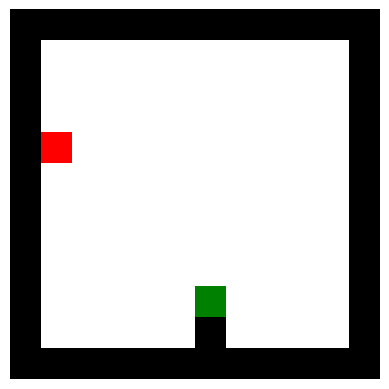

3549


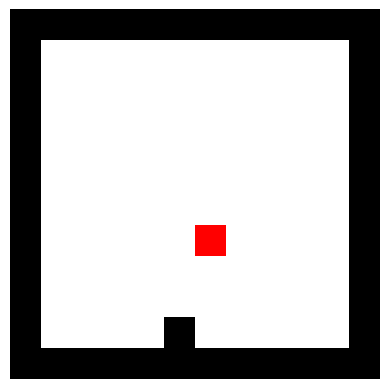

3599


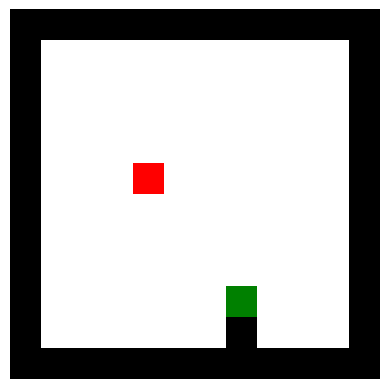

3649


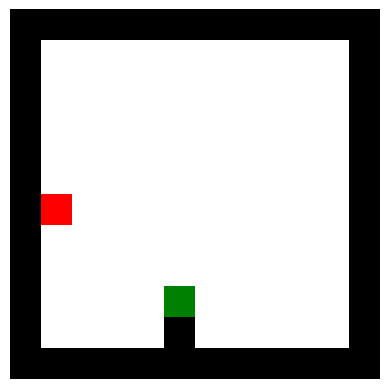

3699


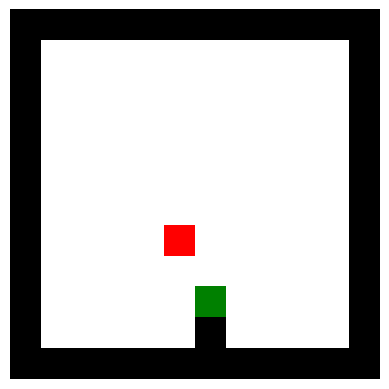

3749


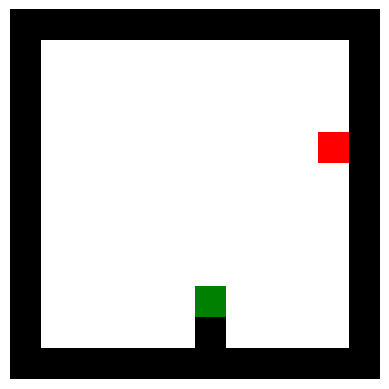

3799


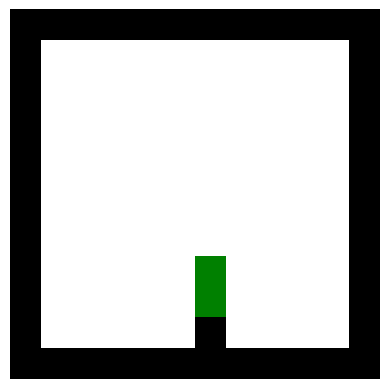

3849


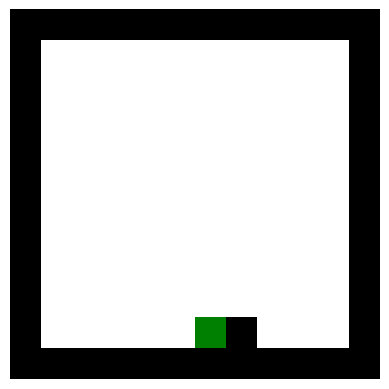

3899


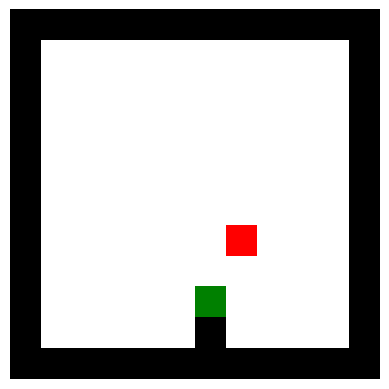

3949


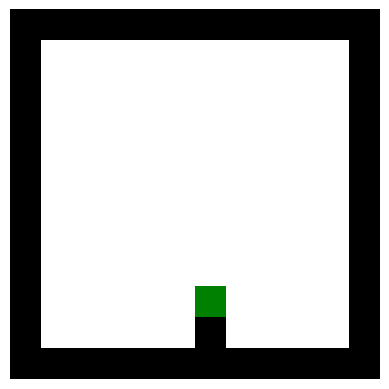

3999


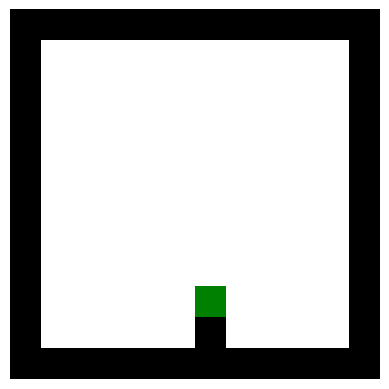

4049


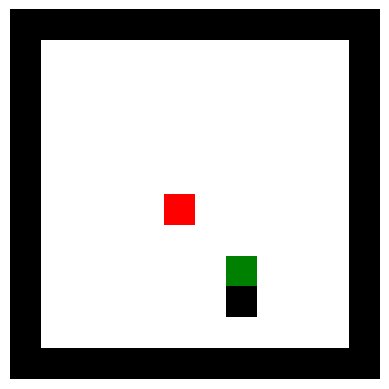

4099


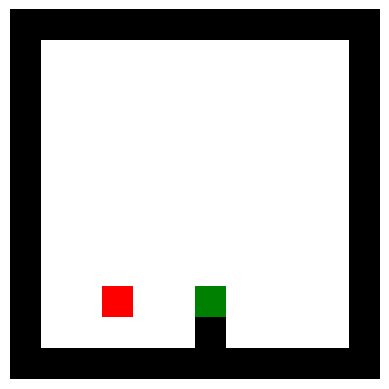

4149


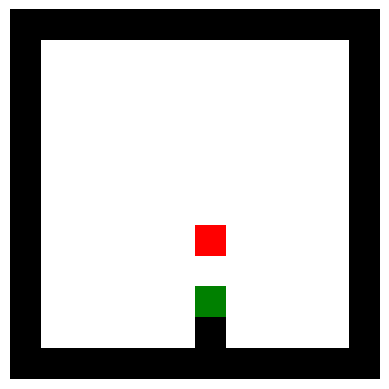

4199


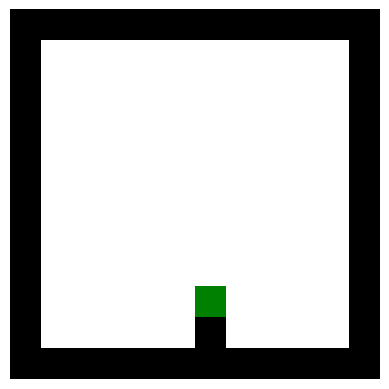

4249


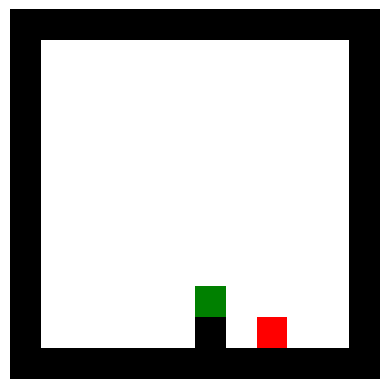

4299


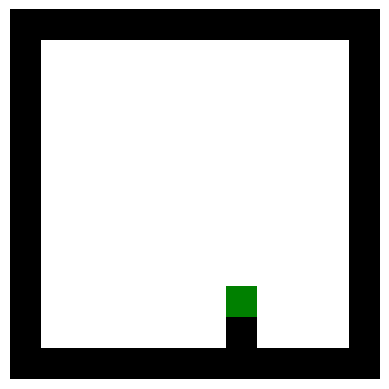

4349


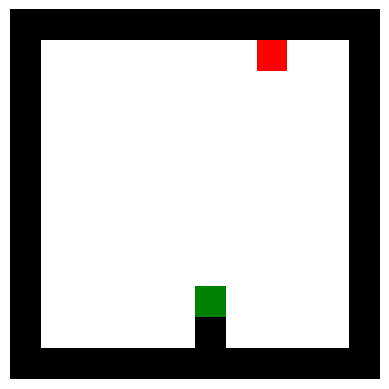

4399


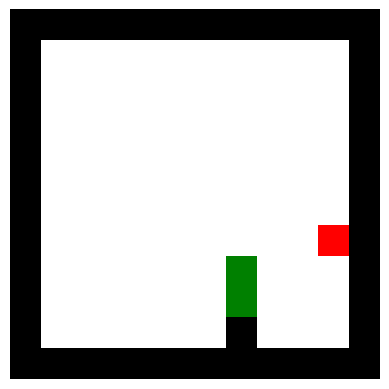

4449


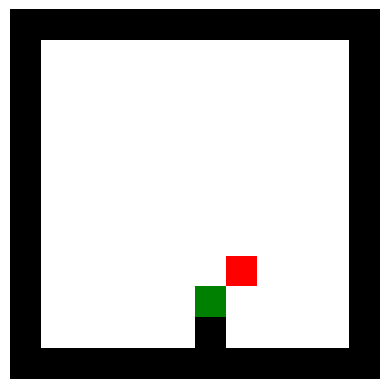

4499


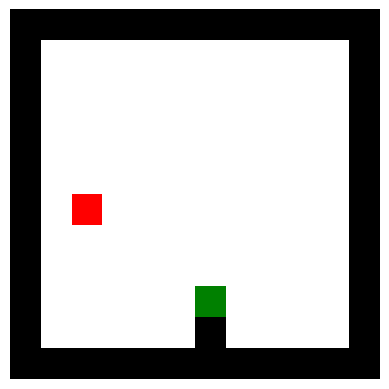

4549


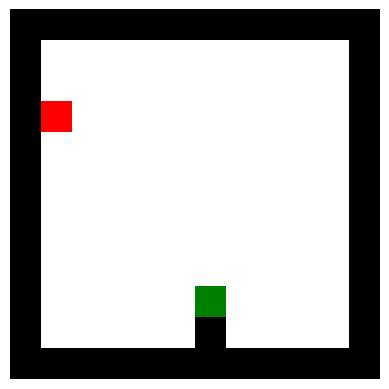

4599


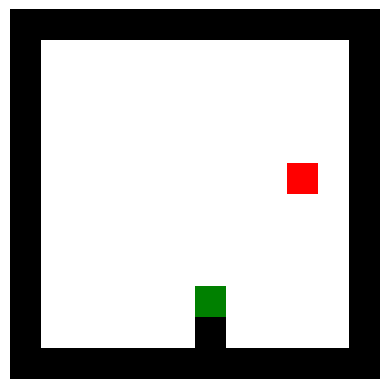

4649


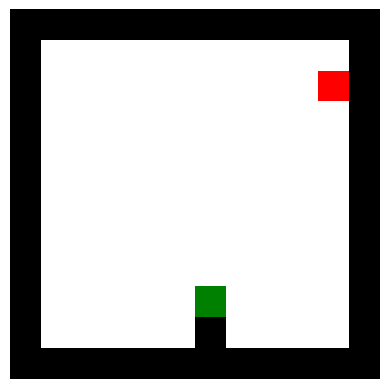

4699


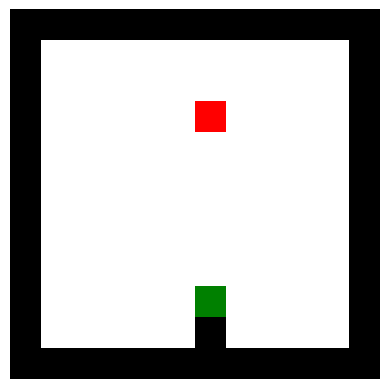

4749


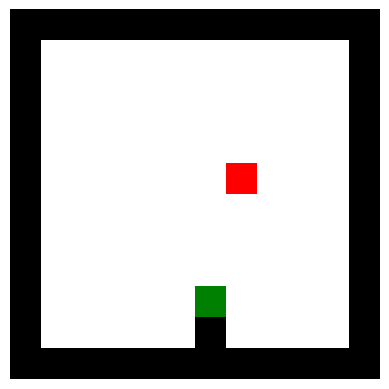

4799


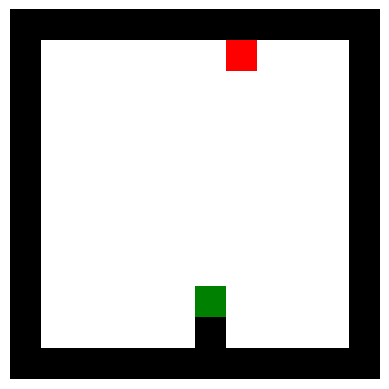

4849


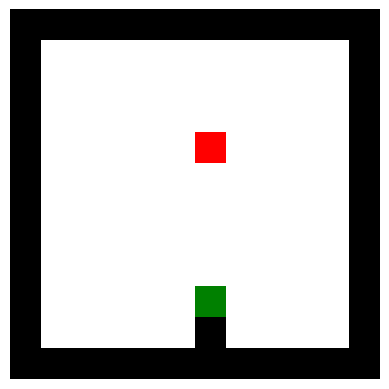

4899


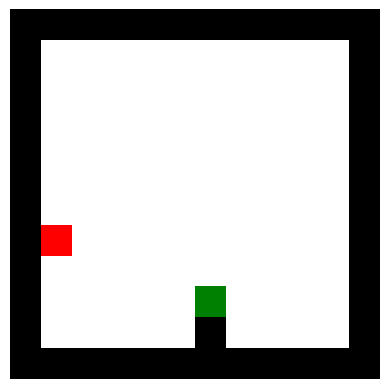

4949


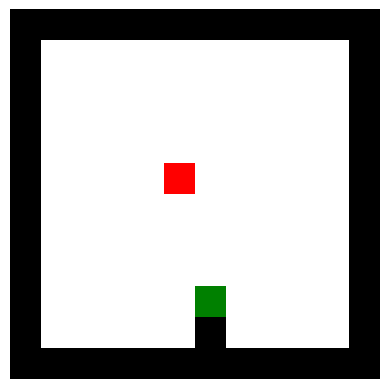

4999


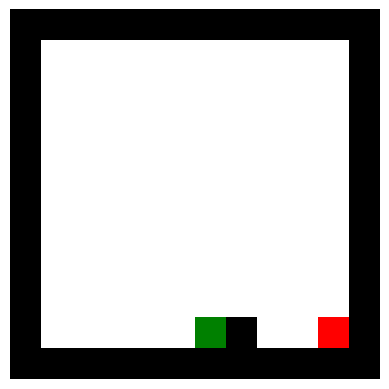

5049


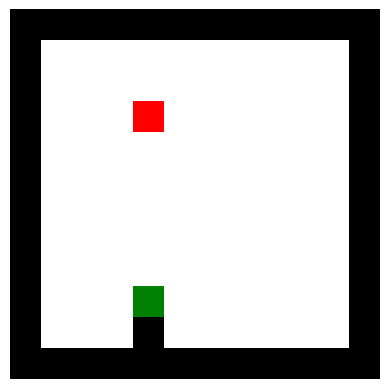

5099


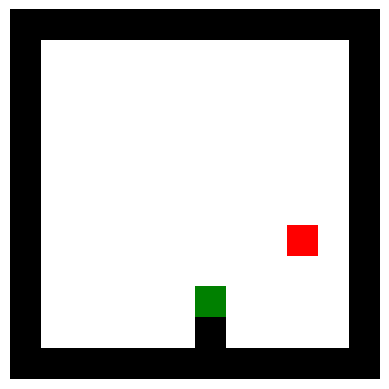

5149


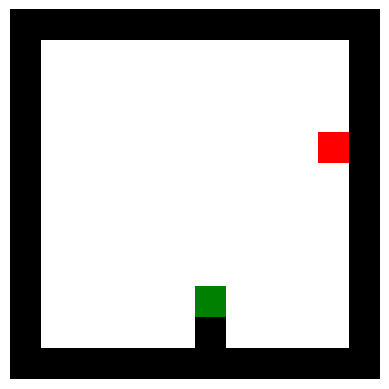

5199


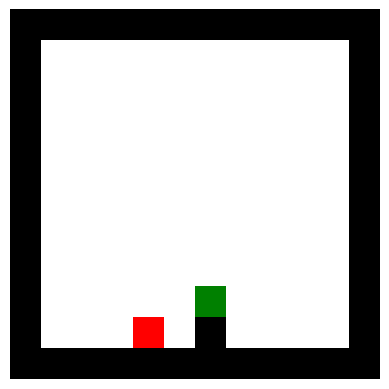

5249


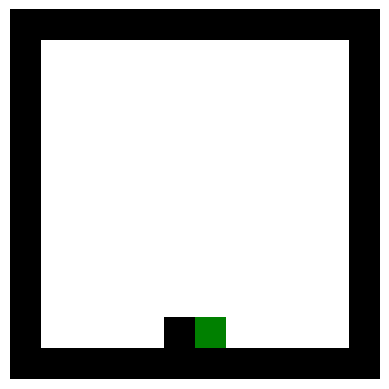

5299


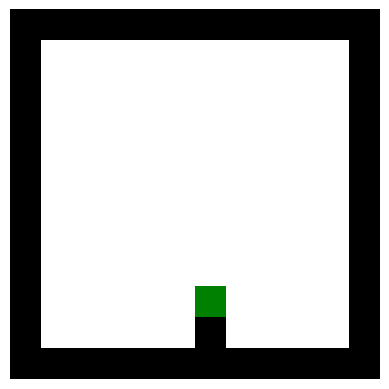

5349


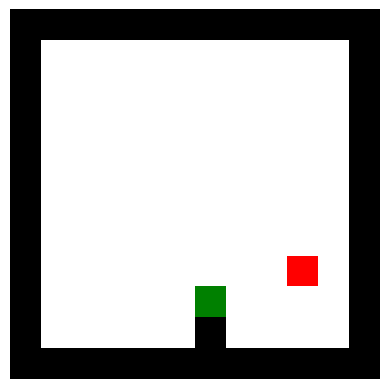

5399


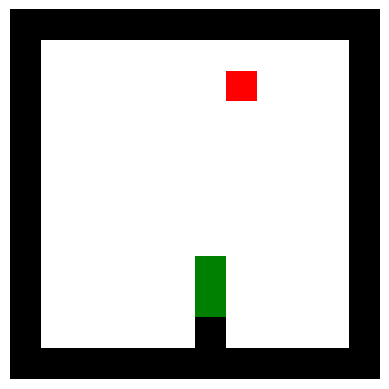

5449


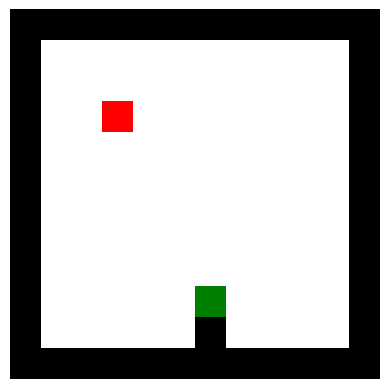

5499


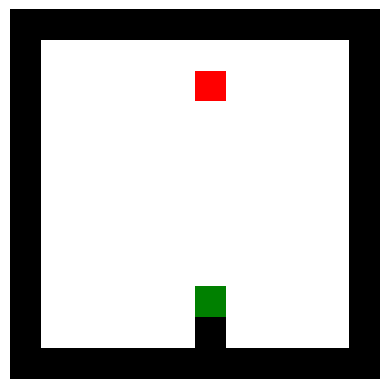

5549


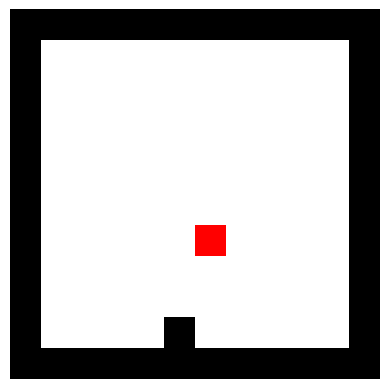

5599


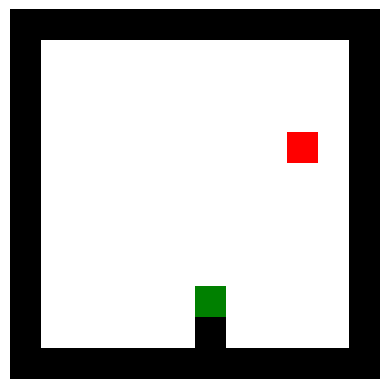

5649


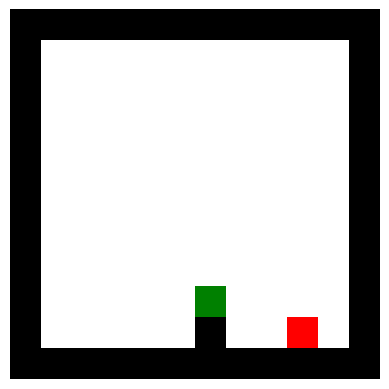

5699


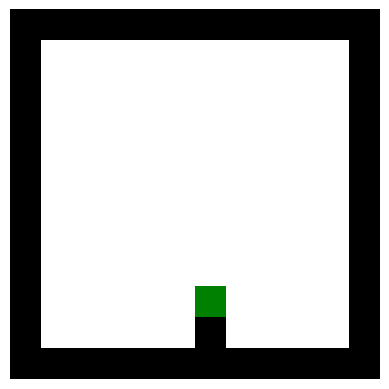

5749


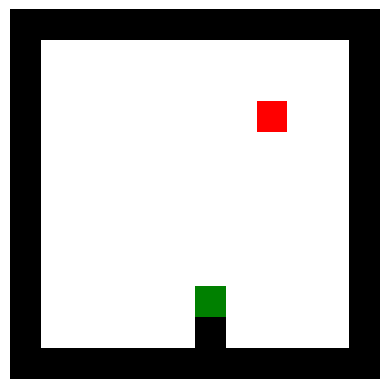

5799


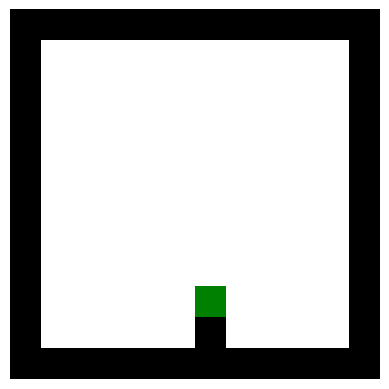

5849


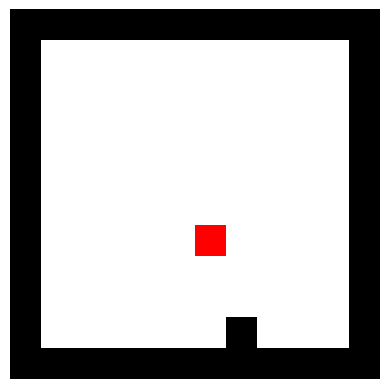

5899


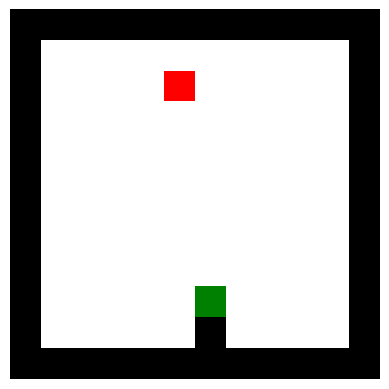

5949


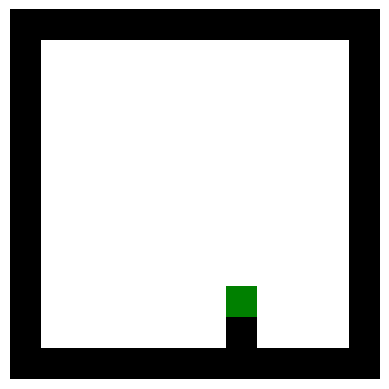

5999


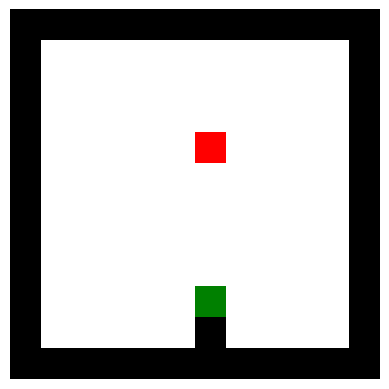

6049


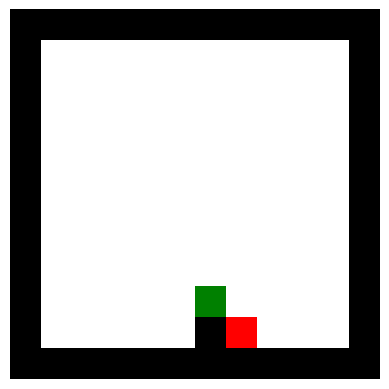

6099


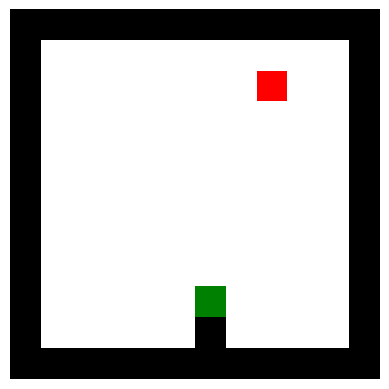

6149


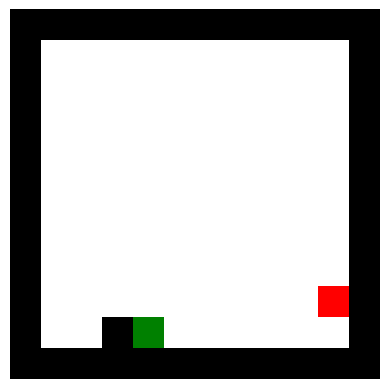

6199


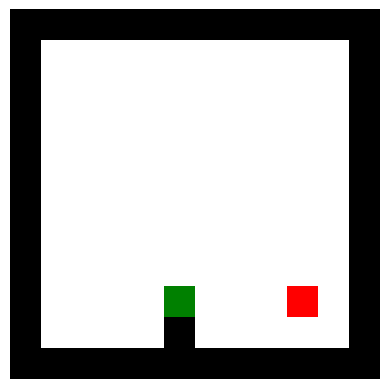

6249


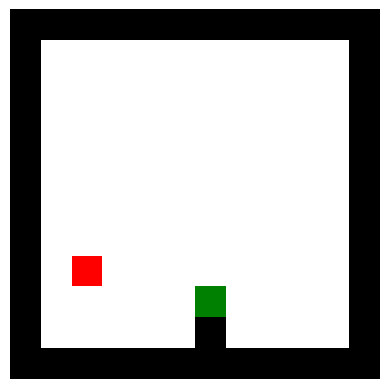

6299


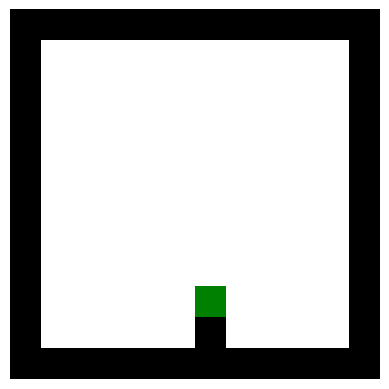

6349


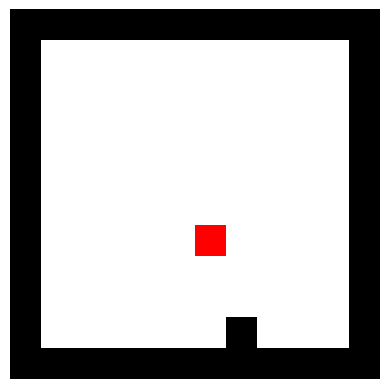

6399


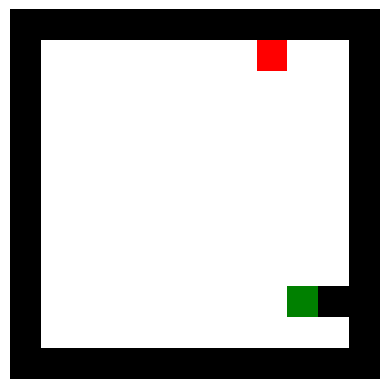

6449


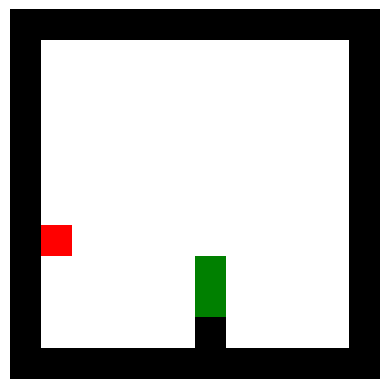

6499


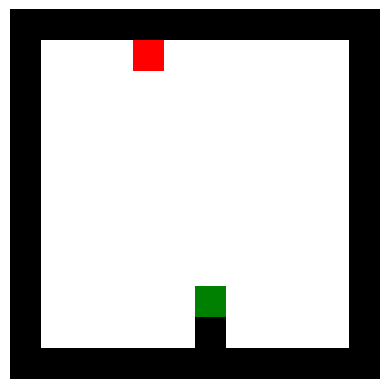

6549


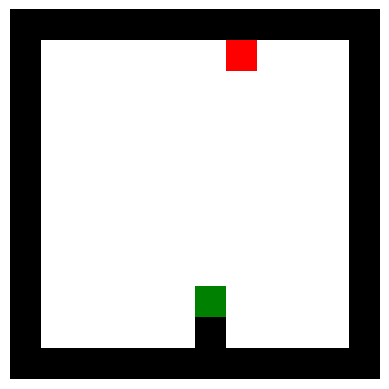

6599


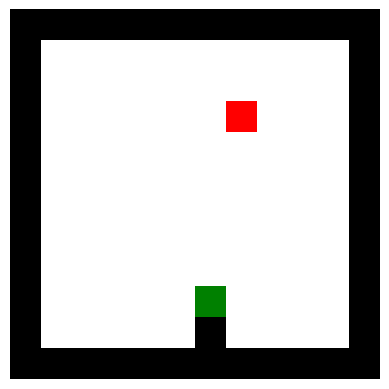

6649


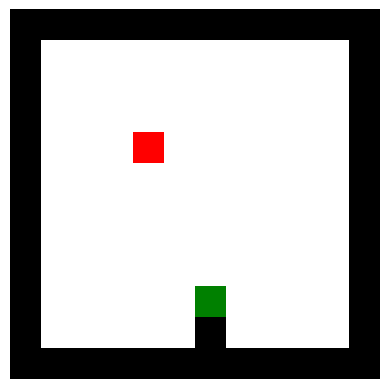

6699


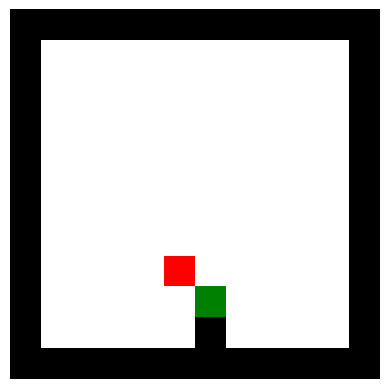

6749


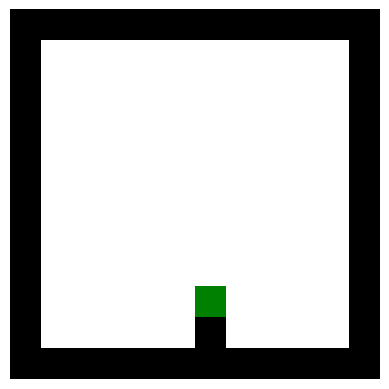

6799


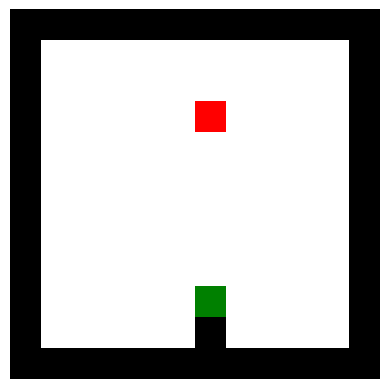

6849


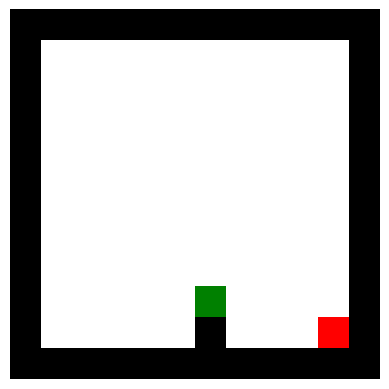

6899


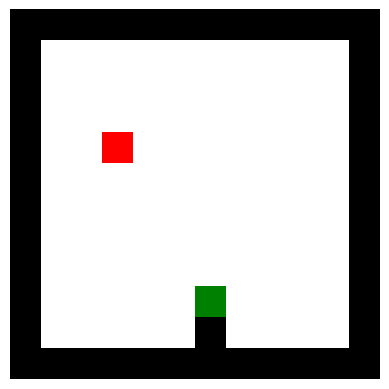

6949


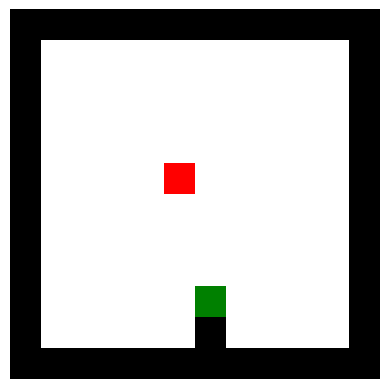

6999


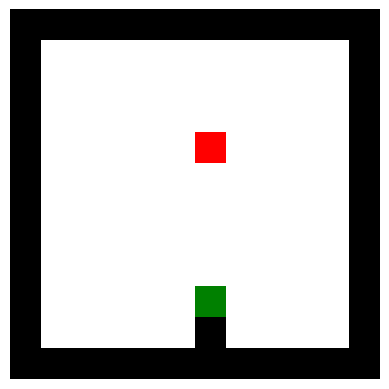

7049


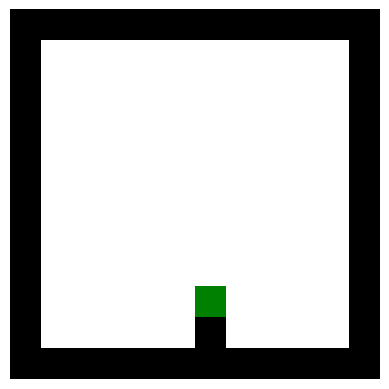

7099


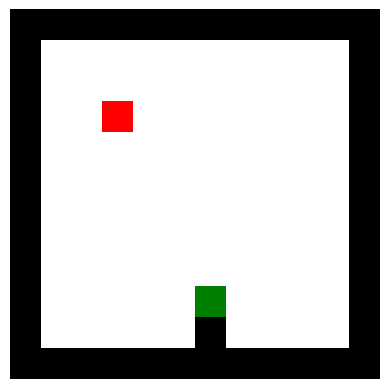

7149


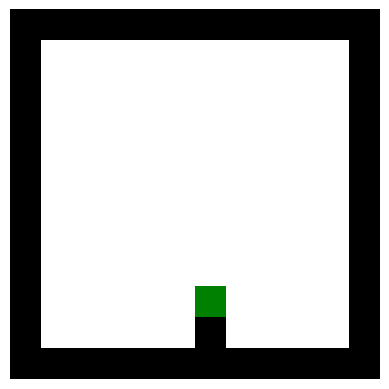

7199


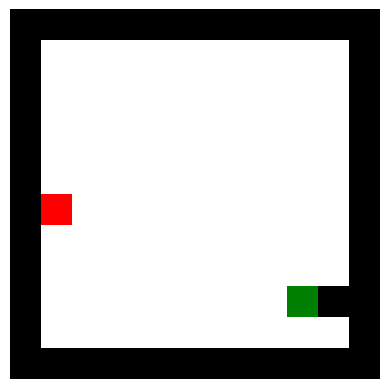

7249


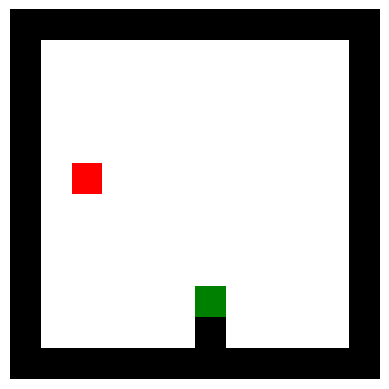

7299


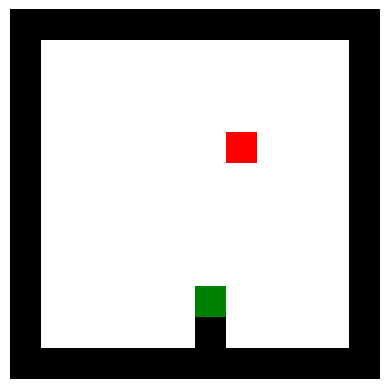

7349


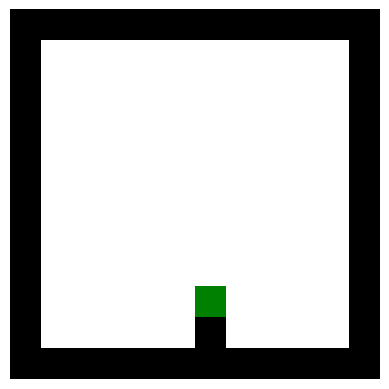

7399


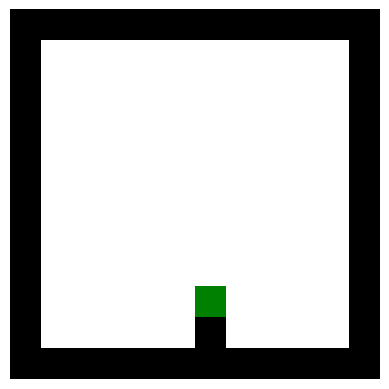

7449


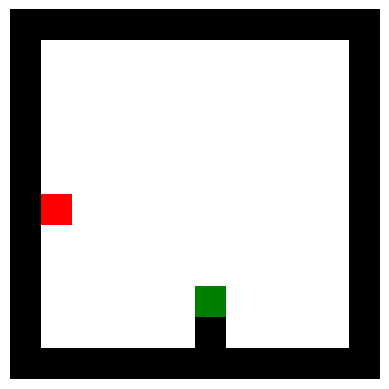

7499


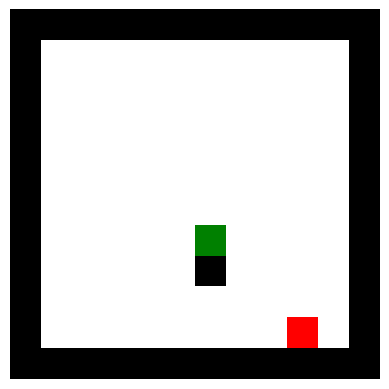

7549


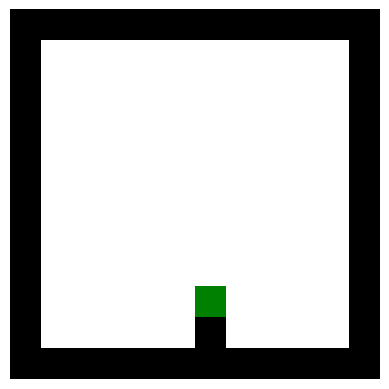

7599


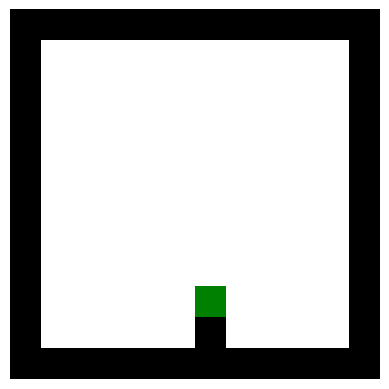

7649


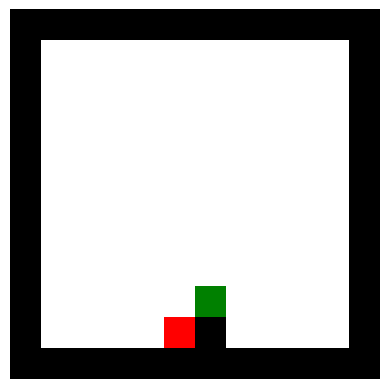

7699


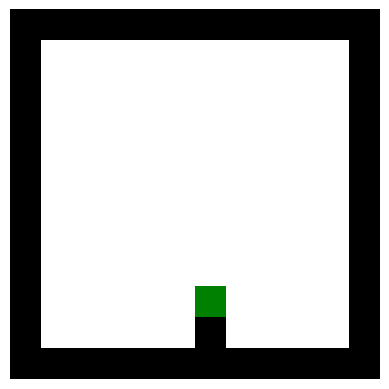

7749


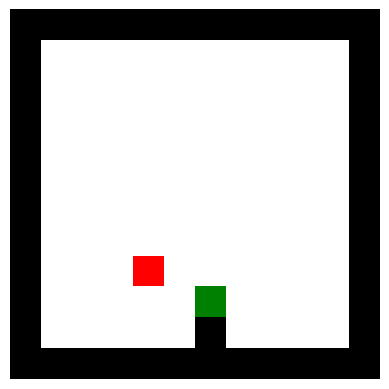

7799


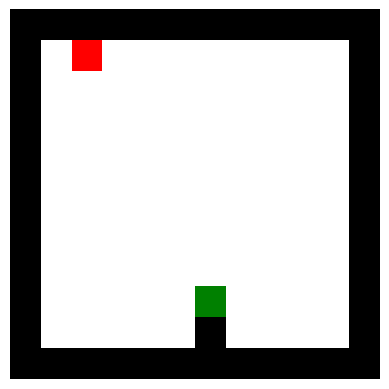

7849


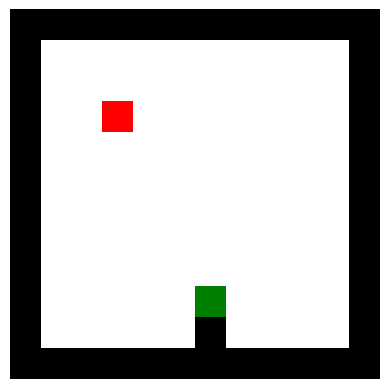

7899


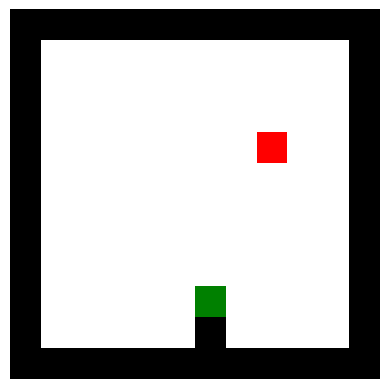

7949


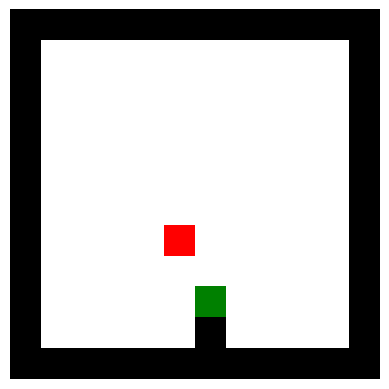

7999


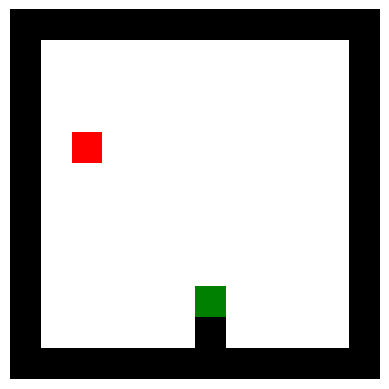

8049


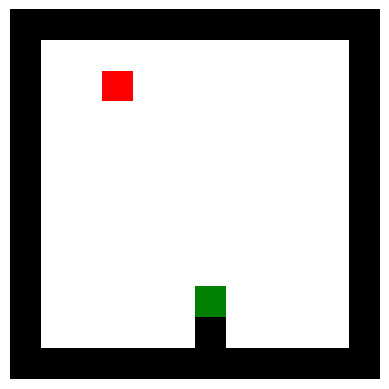

8099


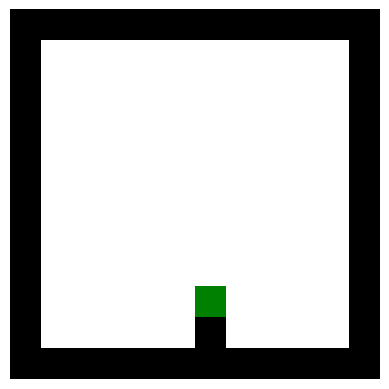

8149


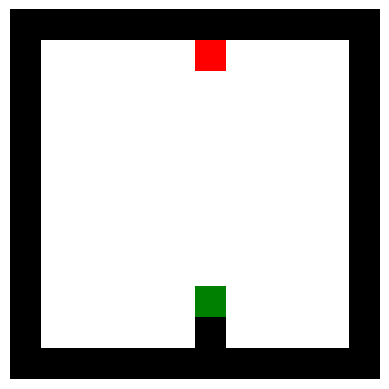

8199


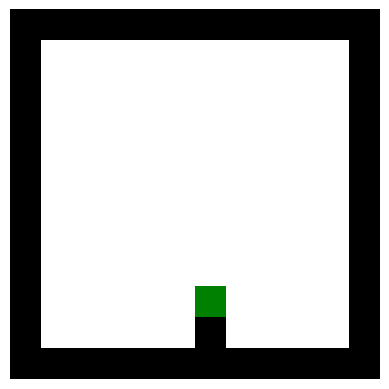

8249


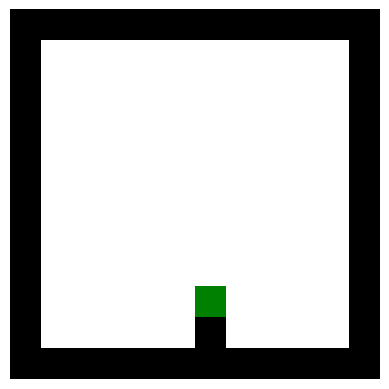

8299


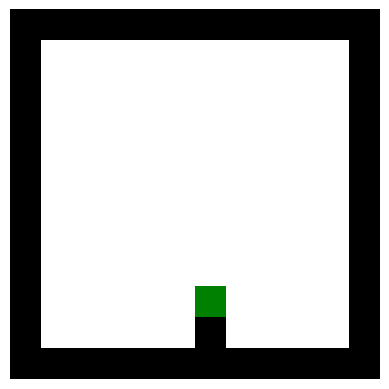

8349


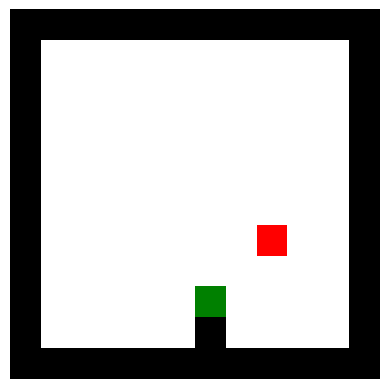

8399


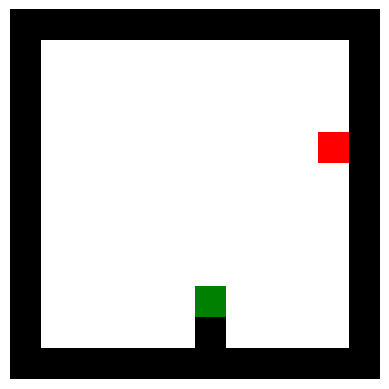

8449


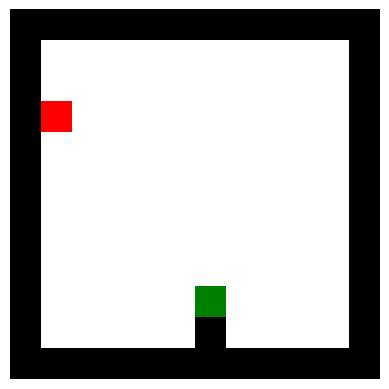

8499


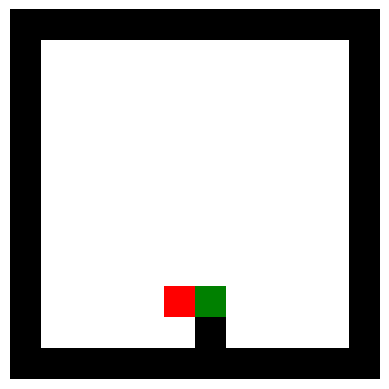

8549


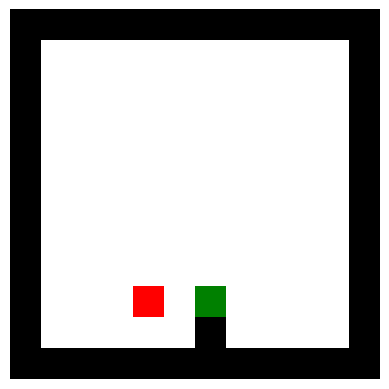

8599


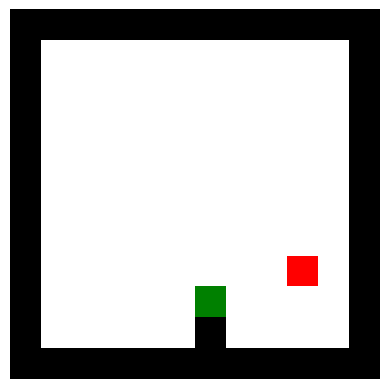

8649


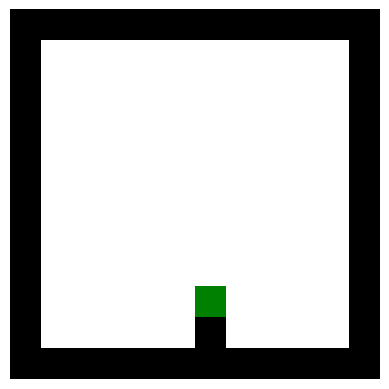

8699


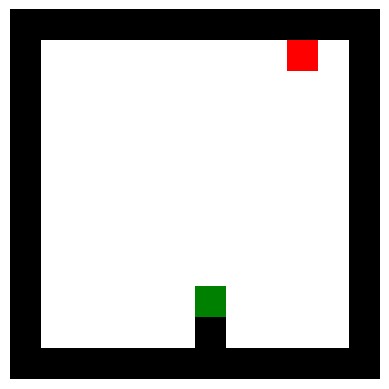

8749


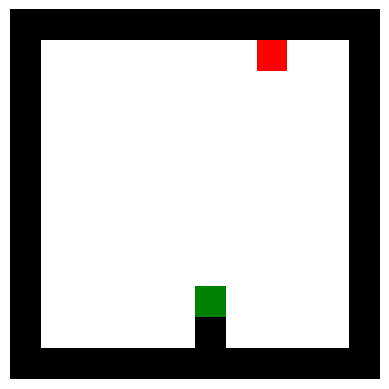

8799


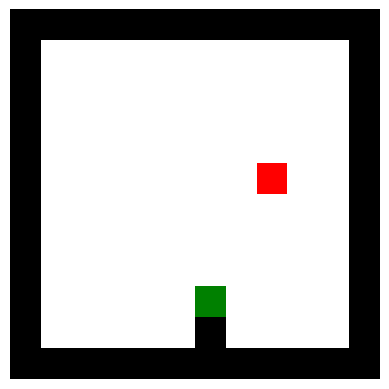

8849


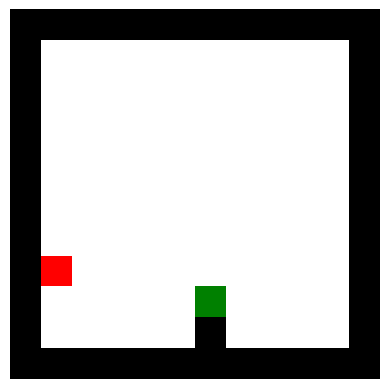

8899


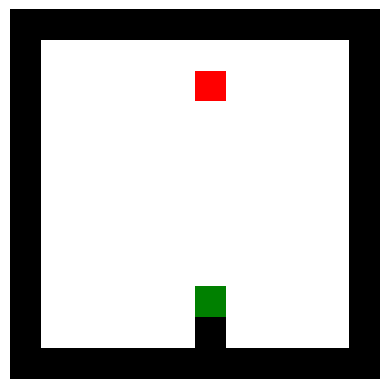

8949


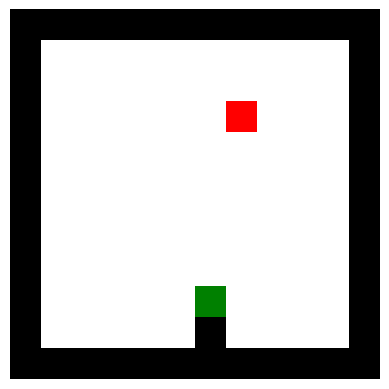

8999


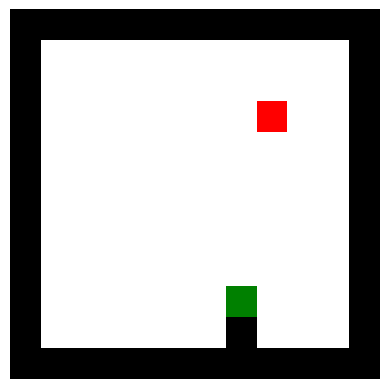

9049


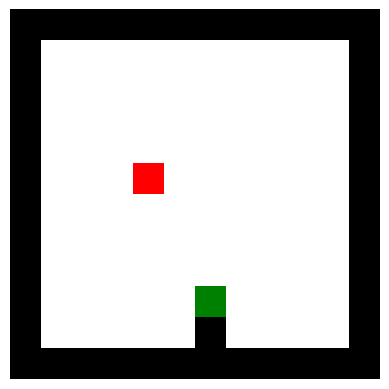

9099


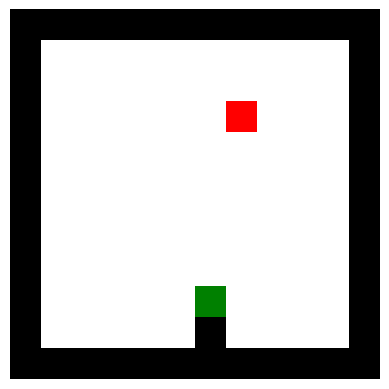

9149


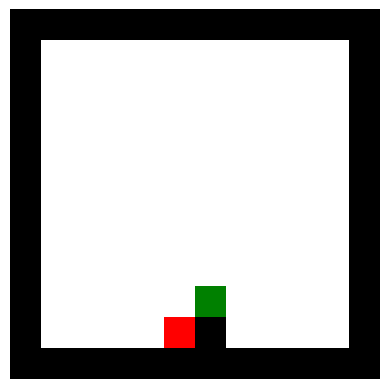

9199


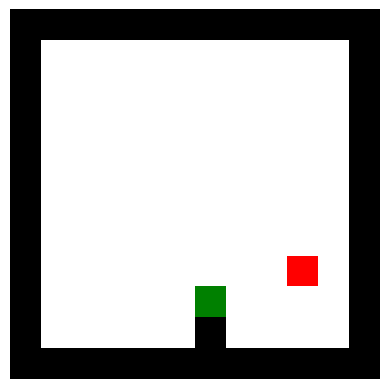

9249


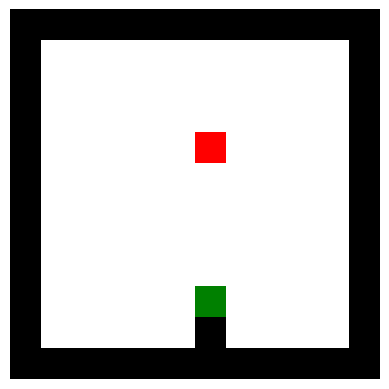

9299


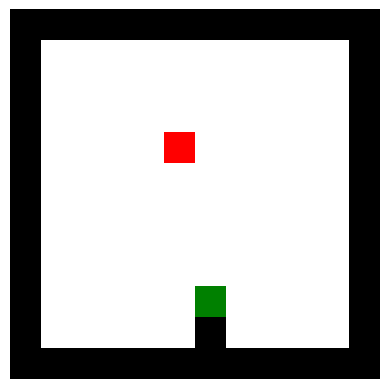

9349


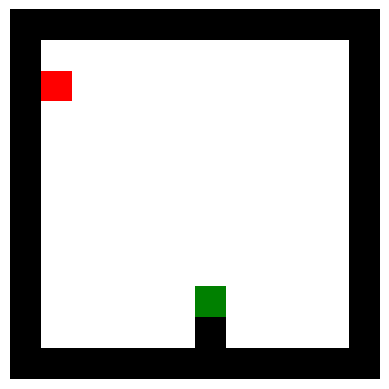

9399


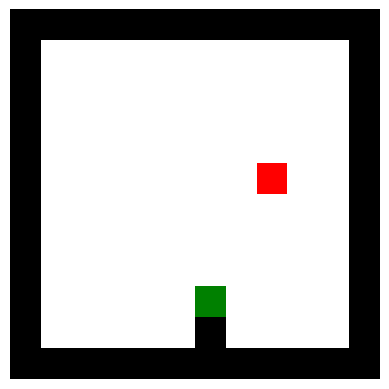

9449


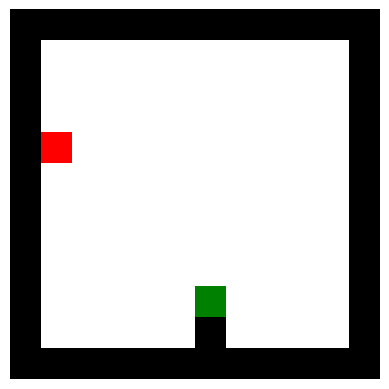

9499


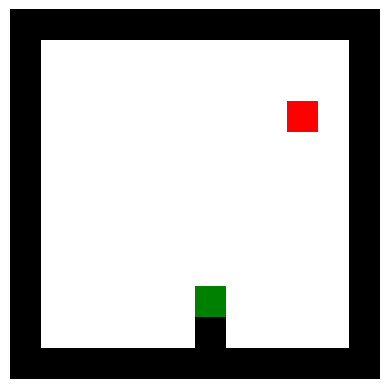

9549


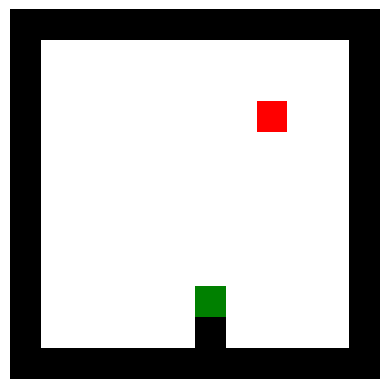

9599


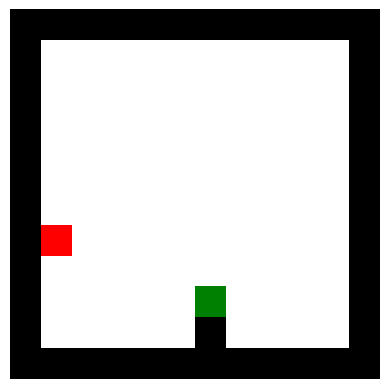

9649


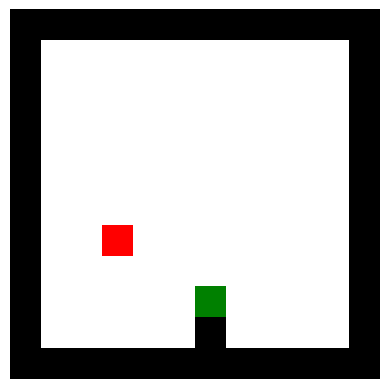

9699


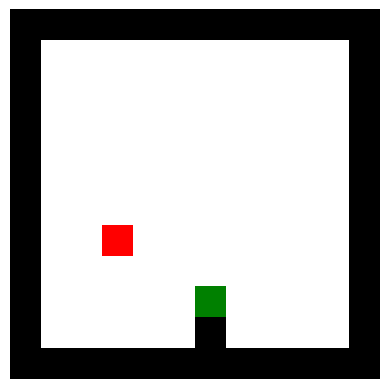

9749


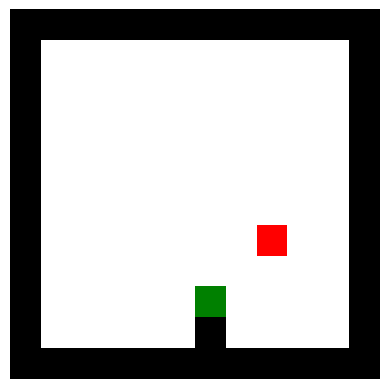

9799


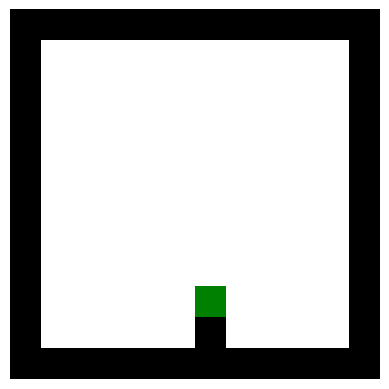

9849


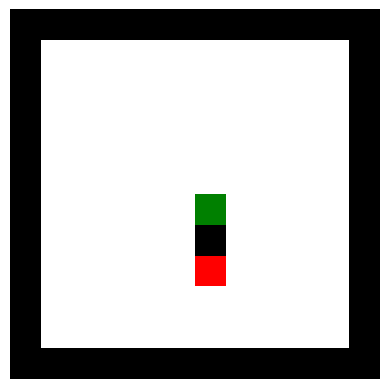

9899


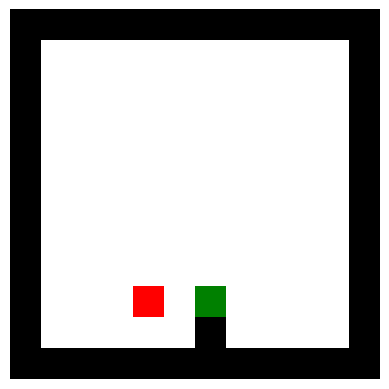

9949


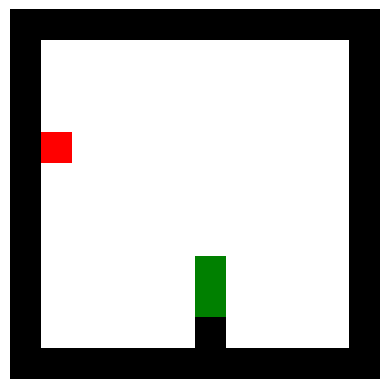

9999


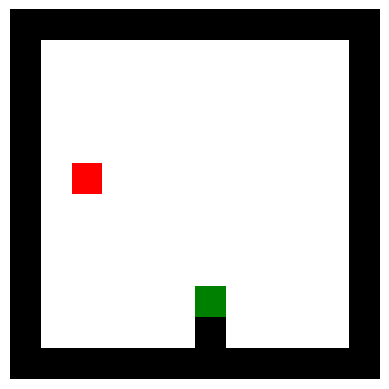

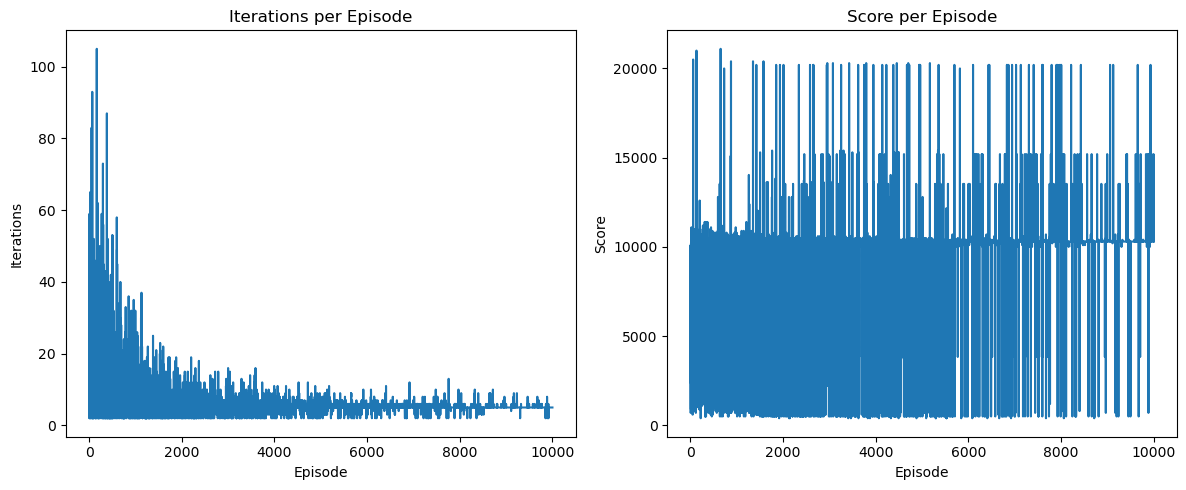

In [10]:
# Hyperparameters

input_dim = TOTAL_GRID_SIZE**2 + 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
agent = DQNAgent(input_dim=input_dim , output_dim=4) # Fill input dimension
action_mapping = {
            0: Direction.UP,
            1: Direction.DOWN,
            2: Direction.LEFT,
            3: Direction.RIGHT
        }
iterations_per_episode = []
scores_per_episode = []
for episode in range(EPISODES):
    iteration_count = 0
    done, snake_queue, apple_location, distance_traveled_to_apple, distance_to_apple, score = initialize_game()
    state = encode_state(snake_queue, apple_location, distance_traveled_to_apple, score)

    while not done:
        iteration_count += 1
        action_index = agent.get_action(state)
        done, snake_queue, apple_location, distance_traveled_to_apple, new_score = update_state(snake_queue, apple_location, distance_traveled_to_apple, action_mapping[action_index], score)
        next_state = encode_state(snake_queue, apple_location, distance_traveled_to_apple, score)
        agent.buffer.push(state, action_index, new_score - score, next_state, done)
        agent.update()
        state = next_state
        score = new_score
    
    iterations_per_episode.append(iteration_count)
    scores_per_episode.append(score)
    
    if (episode + 1) % PRINT_FREQUENCY == 0:
        print(episode)
        game_grid = [state[i:i+TOTAL_GRID_SIZE] for i in range(0, TOTAL_GRID_SIZE**2, TOTAL_GRID_SIZE)]
        plot_game_board(game_grid)
    agent.decay_epsilon()
    if episode % 10 == 0: # Sync every 10 episodes
        agent.sync_target()

plot_series(iterations_per_episode, scores_per_episode)